In [1]:
from sklearn.cluster import KMeans
import numpy as np
import random, torch

In [2]:
# load data
import pickle
import dataset

# load implications
data_file = "../other_datasets/SPECT/preprocessed/spect.pkl"
implication_file = "../other_datasets/SPECT/preprocessed/spect.canonical.pkl"

# get all A→B ∈ L, as pairs of frozensets of attribute index
with open(implication_file, 'rb') as f:
    implications = pickle.load(f)
    print(list(implications)[2])

order, sequence, object_to_concept, attribute_to_concept, extents, intents, context = dataset.load_lattice(data_file)
intents = intents.transpose()
extents.shape, context.shape, intents.shape, attribute_to_concept.shape

(frozenset({0, 8, 11, 20}), frozenset({1, 19, 5, 6}))


((68, 911), (68, 23), (911, 23), (23,))

In [147]:
# apply Attribute2vec model on data (same as o2v, with just a transpose of the contxt and using itents instead of extents)
import object2vec as o2v

vocabulary_length = attribute_to_concept.shape[0]
vocabulary = [i for i in range(vocabulary_length)]
batch_length = 8

intents_ = [[i for i, value in enumerate(intent) if value] for intent in intents]
data = o2v.to_samples(intents_, "CBoW")

batches_CBoW = []
for batch in (data[i:i+batch_length] for i in range(0, len(data), batch_length)):
    inputs, targets = [], []
    offsets = [0]
    for input, target in batch:
        inputs.append(input)
        targets.append(target)
        offsets.append(offsets[-1] + len(input))
    batches_CBoW.append((torch.cat(inputs), torch.tensor(offsets[:-1]), torch.cat(targets),))

data = o2v.to_samples(intents_, "SG")

batches_SG = []
for batch in (data[i:i+batch_length] for i in range(0, len(data), batch_length)):
    inputs, targets = [], []
    for input, target in batch:
        inputs.append(input)
        targets.append(target)
    batches_SG.append((torch.cat(inputs), torch.cat(targets),))

In [154]:
from torch.optim.lr_scheduler import LambdaLR

epochs = 10
embedding_size = 3 #2 or 3 dimensions (l 9 p 15)
num_iter = 20
lr = 1
lambda_ = lambda epoch: lr - (epoch / epochs)


emb_models_list = []
for iteration in range(num_iter):
    for mode in ["SG", "CBoW"]:
        print(iteration, mode)
        model = o2v.Object2Vec(embedding_size, vocabulary_length, mode)
        optim = o2v.torch.optim.Adam(model.parameters(), lr = lr)
        criterion = o2v.nn.CrossEntropyLoss()
        scheduler = LambdaLR(optim, lr_lambda=lambda_)
        if mode == "CBoW":
            for epoch in range(epochs):
                losses = []
                for input, offsets, target in batches_CBoW:
                    #if mode == "CBoW": input = input.view(1,-1) # fake batch
                    out = model(input, offsets)

                    loss = criterion(out, target)

                    loss.backward()
                    optim.step()
                    optim.zero_grad()

                    losses.append(loss.cpu().item())
                
                print(epoch, sum(losses)/len(losses))
                scheduler.step()

            with torch.no_grad():
                attributes = torch.arange(vocabulary_length).view(-1, 1)
                a2v_emb = model.embeddings(attributes)
        else:
            for epoch in range(epochs):
                losses = []
                for input, target in batches_SG:
                    out = model(input)

                    loss = criterion(out, target)

                    loss.backward()
                    optim.step()
                    optim.zero_grad()

                    losses.append(loss.cpu().item())
                
                print(epoch, sum(losses)/len(losses))
                scheduler.step()

            with torch.no_grad():
                attributes = torch.arange(vocabulary_length)
                a2v_emb = model.embeddings(attributes)

        emb_models_list.append((a2v_emb, 'a2v ' + mode, ))

0 SG
0 22.062311139180935
1 18.517096468606006
2 13.304084882875106
3 11.079165986341106
4 8.95649777509171
5 5.721270473379838
6 4.810590316585578
7 4.007806172871266
8 3.267129208464687
9 3.0978292607582394
0 CBoW
0 6.392967408905968
1 4.2500518510127945
2 4.259041585486467
3 3.9639313778265497
4 3.626647439070033
5 3.4402453700352216
6 3.18963380794324
7 3.0666842651283384
8 2.8603521419954214
9 2.645788842638683
1 SG
0 21.30489214292941
1 17.487892312271157
2 14.589279700098981
3 11.64703940978235
4 8.715658243741865
5 6.371522320575645
6 4.629814126088263
7 4.0392402523758
8 3.2433610967909487
9 3.083474227664724
1 CBoW
0 6.525421757270665
1 4.0688507623957415
2 4.763140821708317
3 3.8386890590714655
4 4.007465528478103
5 3.266378796372975
6 3.1480428227640833
7 3.069037443095645
8 2.840073515954043
9 2.640400284203997
2 SG
0 23.372187782146803
1 16.901888346206427
2 14.518082394421555
3 12.140132743646987
4 7.332989572097591
5 6.176192752654408
6 4.760315401985802
7 4.07247301514

In [155]:
torch.save(emb_models_list, 'attribute_task_a2v_models.tch')

In [3]:
from boa_vae import *
emb_models_list = torch.load('attribute_task_a2v_models.tch')
data = torch.load("../concept_models/boa/boa_vae_e500_lr3schedule_b0001_cointent.tch")
with torch.no_grad():
    context_boa = torch.from_numpy(context).float()
    a_embeddings, mu_cointent, logvar = data['encoder'].cpu()(context_boa.view(1, *context_boa.size()))
data = torch.load("../concept_models/boa/boa_vae_e500_lr3schedule_b0001.tch")
with torch.no_grad():
    context_boa = torch.from_numpy(context).float()
    a_embeddings, mu, logvar = data['encoder'].cpu()(context_boa.view(1, *context_boa.size()))

In [4]:
emb_models_list = torch.load('attribute_task_a2v_models.tch')
emb_models_list.append((mu[0].numpy(), 'boa'))

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
a_embeddings_reduced = TSNE(random_state=0, n_components=3).fit_transform(mu[0])
emb_models_list.append((torch.from_numpy(a_embeddings_reduced), 'boa TSNE 3d'))
a_embeddings_reduced = PCA(random_state=0, n_components=3).fit_transform(mu[0])
emb_models_list.append((torch.from_numpy(a_embeddings_reduced), 'boa PCA 3d'))

emb_models_list.append((mu_cointent[0].numpy(), 'boa metric'))
a_embeddings_reduced = TSNE(random_state=0, n_components=3).fit_transform(mu_cointent[0])
emb_models_list.append((torch.from_numpy(a_embeddings_reduced), 'boa metric TSNE 3d'))
a_embeddings_reduced = PCA(random_state=0, n_components=3).fit_transform(mu_cointent[0])
emb_models_list.append((torch.from_numpy(a_embeddings_reduced), 'boa metric PCA 3d'))

In [5]:
results = []
for instance in range(1):
    for emb, model_name in emb_models_list:
        # k-means clustering
        for k in [2,5,10]:
            kmeans = KMeans(n_clusters=k,random_state=3, n_init = 100).fit(emb)

            # transform clustering in sets
            clusters = {i: set() for i in range(k)}
            for i, label in enumerate(kmeans.labels_):
                clusters[label].add(i)

            # intra cluster implications: c∈C such that A∪B⊆c
            intra = 0
            for implication in implications:
                implication_set = implication[0].union(implication[0])
                for cluster in clusters.values():
                    if implication_set <= cluster:
                        intra += 1
                        break
            
            intra_ratio = intra / len(implications)
            results.append({"model": model_name, "intra-cluster implications": intra_ratio, "k": k})

KeyboardInterrupt: 

In [200]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame.from_records(results)
df.to_csv("attribute_task.csv")

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv("attribute_task.csv")

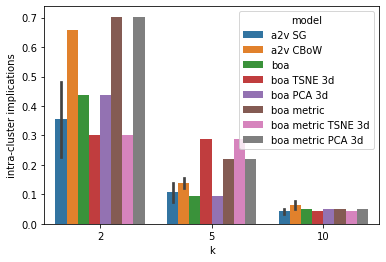

In [7]:
sns.barplot(data=df, hue='model', y = 'intra-cluster implications', x='k', ci="sd",
hue_order=['a2v SG', 'a2v CBoW',
    'boa', 'boa TSNE 3d', 'boa PCA 3d', 'boa metric', 'boa metric TSNE 3d', 'boa metric PCA 3d'])
plt.savefig("attribute_task.png")

In [8]:
stats = {}
for k in [2,5,10]:
    mean = df[df['k']==k].groupby('model')['intra-cluster implications'].mean()
    sd = df[df['k']==k].groupby('model')['intra-cluster implications'].std()
    stats[k] = pd.concat([mean, sd], axis=1, keys=['mean', 'std'])
stats = pd.concat([stats[2], stats[5], stats[10]], axis=1, keys=['k = 2','k = 5','k = 10'])

In [9]:
print(stats.to_markdown())
stats

| model              |   ('k = 2', 'mean') |   ('k = 2', 'std') |   ('k = 5', 'mean') |   ('k = 5', 'std') |   ('k = 10', 'mean') |   ('k = 10', 'std') |
|:-------------------|--------------------:|-------------------:|--------------------:|-------------------:|---------------------:|--------------------:|
| a2v CBoW           |            0.658703 |           0        |           0.138567  |          0.0158311 |            0.0634812 |           0.0132137 |
| a2v SG             |            0.354778 |           0.129648 |           0.106826  |          0.0333502 |            0.0423208 |           0.0098669 |
| boa                |            0.43686  |         nan        |           0.0955631 |        nan         |            0.0511945 |         nan         |
| boa PCA 3d         |            0.43686  |         nan        |           0.0955631 |        nan         |            0.0511945 |         nan         |
| boa TSNE 3d        |            0.300341 |         nan        |           

k = 2               k = 5              k = 10          
                        mean       std      mean       std      mean       std
model                                                                         
a2v CBoW            0.658703  0.000000  0.138567  0.015831  0.063481  0.013214
a2v SG              0.354778  0.129648  0.106826  0.033350  0.042321  0.009867
boa                 0.436860       NaN  0.095563       NaN  0.051195       NaN
boa PCA 3d          0.436860       NaN  0.095563       NaN  0.051195       NaN
boa TSNE 3d         0.300341       NaN  0.286689       NaN  0.044369       NaN
boa metric          0.703072       NaN  0.218430       NaN  0.051195       NaN
boa metric PCA 3d   0.703072       NaN  0.218430       NaN  0.051195       NaN
boa metric TSNE 3d  0.300341       NaN  0.286689       NaN  0.044369       NaN

In [11]:
print(stats.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{2}{l}{k = 2} & \multicolumn{2}{l}{k = 5} & \multicolumn{2}{l}{k = 10} \\
{} &      mean &       std &      mean &       std &      mean &       std \\
model              &           &           &           &           &           &           \\
\midrule
a2v CBoW           &  0.658703 &  0.000000 &  0.138567 &  0.015831 &  0.063481 &  0.013214 \\
a2v SG             &  0.354778 &  0.129648 &  0.106826 &  0.033350 &  0.042321 &  0.009867 \\
boa                &  0.436860 &       NaN &  0.095563 &       NaN &  0.051195 &       NaN \\
boa PCA 3d         &  0.436860 &       NaN &  0.095563 &       NaN &  0.051195 &       NaN \\
boa TSNE 3d        &  0.300341 &       NaN &  0.286689 &       NaN &  0.044369 &       NaN \\
boa metric         &  0.703072 &       NaN &  0.218430 &       NaN &  0.051195 &       NaN \\
boa metric PCA 3d  &  0.703072 &       NaN &  0.218430 &       NaN &  0.051195 &       NaN \\
boa metric TSNE 3d &  0.300341 &    

In [191]:
help(df[df['k']==2].groupby('model').describe)

Help on method describe in module pandas.core.groupby.groupby:

describe(**kwargs) method of pandas.core.groupby.generic.DataFrameGroupBy instance
    Generate descriptive statistics.
    
    Descriptive statistics include those that summarize the central
    tendency, dispersion and shape of a
    dataset's distribution, excluding ``NaN`` values.
    
    Analyzes both numeric and object series, as well
    as ``DataFrame`` column sets of mixed data types. The output
    will vary depending on what is provided. Refer to the notes
    below for more detail.
    
    Parameters
    ----------
    percentiles : list-like of numbers, optional
        The percentiles to include in the output. All should
        fall between 0 and 1. The default is
        ``[.25, .5, .75]``, which returns the 25th, 50th, and
        75th percentiles.
    include : 'all', list-like of dtypes or None (default), optional
        A white list of data types to include in the result. Ignored
        for ``Serie

In [12]:
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_1samp
import numpy

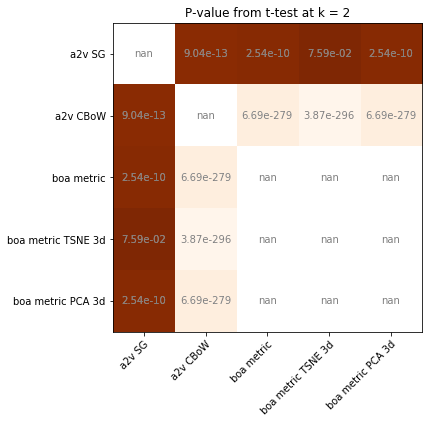

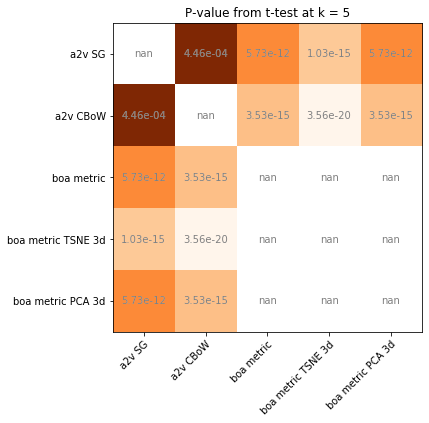

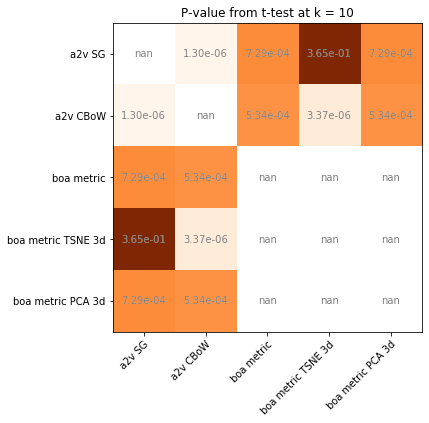

In [14]:
for k in [2,5,10]:
    df_ = df[df['k'] == k]
    #models = ['a2v SG', 'a2v CBoW', 'boa', 'boa TSNE 3d', 'boa PCA 3d', 'boa metric', 'boa metric TSNE 3d', 'boa metric PCA 3d']
    models = ['a2v SG', 'a2v CBoW', 'boa metric', 'boa metric TSNE 3d', 'boa metric PCA 3d']
    ps = np.ndarray((len(models), len(models),))
    for i, first_model in enumerate(models):
        for j, second_model in enumerate(models):
            if i != j:
                first_df = df_[df_['model'] == first_model]['intra-cluster implications']
                second_df = df_[df_['model'] == second_model]['intra-cluster implications']
                if len(first_df) > 1:
                    if len(second_df) > 1:
                        p = ttest_ind(first_df, second_df)[1]
                    else:
                        p = ttest_1samp(first_df, second_df)[1]
                else:
                    if len(second_df) > 1:
                        p = ttest_1samp(second_df, first_df)[1]
                    else:
                        p = 'nan'
            else:
                p = 'nan'
            ps[i, j] = p


    #fig, ax = plt.subplots(figsize=(10,10))
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(np.log(ps), cmap="Oranges")#Dark2_r

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(models)))
    ax.set_yticks(np.arange(len(models)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(models)
    ax.set_yticklabels(models)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(models)):
        for j in range(len(models)):
            if ps[i, j] != np.float('nan'):
                text = ax.text(j, i, f"{ps[i, j]:.2e}",
                            ha="center", va="center", color="w")
                text = ax.text(j, i, f"{ps[i, j]:.2e}",
                            ha="center", va="center", color="black", alpha=.5)

    ax.set_title(f"P-value from t-test at k = {k}")
    fig.tight_layout()
    plt.show()

In [ ]:
Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

In [178]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=<deprecated parameter>, filternorm=1, filterrad=4.0, imlim=<deprecated parameter>, resample=None, url=None, *, data=None, **kwargs)
    Display an image, i.e. data on a 2D regular raster.
    
    Parameters
    ----------
    X : array-like or PIL image
        The image data. Supported array shapes are:
    
        - (M, N): an image with scalar data. The data is visualized
          using a colormap.
        - (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
        - (M, N, 4): an image with RGBA values (0-1 float or 0-255 int),
          i.e. including transparency.
    
        The first two dimensions (M, N) define the rows and columns of
        the image.
    
        Out-of-range RGB(A) values are clipped.
    
    cmap : str or `~matplotlib.colors.Colormap`, optional
        The 

In [ ]:
plot pca and ...

plot plateau of reconstruction for larger data
    need results ASAP so keep to simplistic natural data




tool:
    contribution
        pros & cons
    what input what output
    how can be used
    limit

more exoloratory than conclusive
    explore caracteristics
    sensitivity to pertubation
        - compare when changing order of attributes/objects -> should not vary
        - compare when changing padding amount -> should not vary much
        - compare when drops -> should vary
    use

subsection in intro
    1 paragraph with 'what is really new', clear contribution -> abstract
    mention exploratory paper, ment to reach lattice generation
    why not doing all the experiments

why important to publish

references come into play as a support to the "agnostic to the data""flexible approach to fca"

how unsupervised clustering can be usefull

patterns to new space is useful

case by case benefits


In [2]:
(22-14)/14, 4/66

0.5714285714285714